In [1]:
import numpy as np
import matplotlib.pyplot as plt
import george
from george import kernels
from astropy.timeseries import LombScargle
import random 
from scipy.stats import loguniform, gamma, uniform
import time 
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import pickle

2023-05-16 15:31:43.794003: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Generate time and frequency

#Over-sampling
Ttot = 200 # days
facteur_surech = 10
N = Ttot*facteur_surech +1 # number of data point in a regularly sampled grid
t_over = np.linspace(0,Ttot,N) #days
dt = Ttot*facteur_surech/(N-1) #After sampling


# Irregular sampling 1 : with normal distribution
facteur_ech = 10
t = np.zeros(Ttot)

ind0 = round( 0 + facteur_ech*np.abs(np.random.normal(0, 0.1)))
t[0] = t_over[ ind0 ]
ind_fin = round( (N-1) - facteur_ech*np.abs(np.random.normal(0, 0.1)))
t[-1] = t_over[ ind_fin ]

pas = N/Ttot
for i in range(Ttot-2):
    ind = round((i+1)*pas+facteur_ech*np.random.normal(0, 0.1))
    t[i+1] =  t_over[ind]
    
fmin = 1/Ttot
fmax = (1/dt)/2 
freq = np.arange(fmin,fmax,fmin/10)

In [3]:
#Load dataset 1 for the neural network
X_LS = np.load('./data/set1/X_LS.npy', allow_pickle=True)
X_max_values = np.load('./data/set1/X_max_values.npy', allow_pickle=True)
Y = np.load('./data/set1/Y.npy', allow_pickle=True)

In [4]:
N_data = len(X_LS)
print("X_lS : ", len(X_LS), type(X_LS))
print("X_max_values : ", len(X_max_values), type(X_max_values))

print("\n1 periodogramme : ",len(X_LS[0]), type(X_LS[0]) ) #periodogramme
print("1 max values : ", len(X_max_values[0]), type(X_max_values[0]) ) #max values 

print("Y : ", len(Y), type(Y))

X_lS :  13700 <class 'numpy.ndarray'>
X_max_values :  13700 <class 'numpy.ndarray'>

1 periodogramme :  990 <class 'numpy.ndarray'>
1 max values :  2 <class 'numpy.ndarray'>
Y :  13700 <class 'numpy.ndarray'>


In [5]:
#Data pre-processing 

#shuffle
c = list(zip(X_LS, X_max_values,Y))
random.shuffle(c)
X_LS, X_max_values,Y = zip(*c)

#Periodogramme
X1 = tf.convert_to_tensor(X_LS, dtype= 'float32')
X_shape =  [N_data,len(X_LS[0]), 1]
X1 = tf.reshape(X1, X_shape )

#Max values
X2 = tf.convert_to_tensor(X_max_values, dtype= 'float32')
X2 = tf.reshape(X2, (N_data, 2,1))

#Label
Y = tf.convert_to_tensor(Y)
Y = tf.reshape(Y, (N_data,1 ))

#Split train/validation
X_train1, X_test1 = X1[0:10000, :, :], X1[10000:, :, :]
X_train2,X_test2 = X2[0:10000, :, :], X2[10000:, :, :]
Y_train, Y_test = Y[0:10000], Y[10000:,:]

print("Periodogramme train size : ", X_train1.shape)
print("Periodogramme test size : ", X_test1.shape)
print("\n")
print("Max_values train size : ", X_train2.shape)
print("Max_values test size : ", X_test2.shape)
print("\n")
print("Label train size : ", Y_train.shape)
print("Label test size : ", Y_test.shape)

Periodogramme train size :  (10000, 990, 1)
Periodogramme test size :  (3700, 990, 1)


Max_values train size :  (10000, 2, 1)
Max_values test size :  (3700, 2, 1)


Label train size :  (10000, 1)
Label test size :  (3700, 1)


2023-05-16 15:31:59.726095: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
#Model with functional API Keras

#periodogramme as input to a CNN
inputs1 = tf.keras.Input(shape=(990,1))
x1 = layers.Conv1D(filters = 32, kernel_size = 2, strides = 1, padding = 'same',
                   activation='relu', use_bias = True,input_shape= (990,))(inputs1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
x1 = layers.Conv1D(32,6,padding = 'same', activation='relu')(x1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
x1 = layers.Conv1D(32,8,padding = 'same', activation='relu')(x1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
outputs1 = layers.Flatten()(x1)

#max_values as input to a dense layers 
inputs2 = tf.keras.Input(shape=(2,1))
x2 = layers.Dense(2, activation = 'relu')(inputs2)
outputs2 =  layers.Flatten()(x2)

#output of the two network concatenate for input as a dense final network
x = layers.concatenate([outputs1, outputs2])

x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)


In [7]:
model = tf.keras.Model(inputs=[inputs1,inputs2], outputs=outputs, name ="ExoplANNET")

In [8]:
model.summary()

Model: "ExoplANNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 990, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 990, 32)      96          ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 495, 32)      0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 495, 32)      6176        ['max_pooling1d[0][0]']          
                                                                                         

In [9]:
#Create metrics for trainning
from tensorflow.keras import backend as K

def precision_m(y_true, y_pred):
    true_positives = K.sum( K.round(K.clip(y_true*y_pred,0,1)) )
    predicted_positives = K.sum( K.round(K.clip(y_pred,0,1)) )
    return true_positives / ( predicted_positives + K.epsilon())

def recall_m(y_true, y_pred):
    true_positives = K.sum( K.round(K.clip(y_true*y_pred,0,1)) )
    real_positives = K.sum( K.round(K.clip(y_true,0,1)) )
    return true_positives / (real_positives + K.epsilon())

def f_score(y_true, y_pred):
    P = precision_m(y_true, y_pred)
    R = recall_m(y_true, y_pred)
    return (2*P*R) / (P+R+K.epsilon())


In [10]:
#Train the network
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'f_score', patience = 3, mode = "max",
                                                  restore_best_weights = True, start_from_epoch = 5)

model.compile( loss = tf.keras.losses.BinaryCrossentropy(from_logits= False),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
              metrics =[tf.keras.metrics.BinaryAccuracy(),precision_m, recall_m, f_score])

start = time.time()
history = model.fit(x = [X_train1, X_train2], y = Y_train, batch_size = 128, epochs = 50, 
                    verbose = 1, callbacks=[early_stopping])
time_train = time.time() - start

Epoch 1/50
79/79 [==============================] - 15s 162ms/step - loss: 0.5637 - binary_accuracy: 0.6900 - precision_m: 0.6388 - recall_m: 0.5773 - f_score: 0.5711
Epoch 2/50
79/79 [==============================] - 14s 175ms/step - loss: 0.4856 - binary_accuracy: 0.7342 - precision_m: 0.6354 - recall_m: 0.8204 - f_score: 0.7142
Epoch 3/50
79/79 [==============================] - 14s 175ms/step - loss: 0.4646 - binary_accuracy: 0.7440 - precision_m: 0.6357 - recall_m: 0.8645 - f_score: 0.7303
Epoch 4/50
79/79 [==============================] - 14s 175ms/step - loss: 0.4504 - binary_accuracy: 0.7556 - precision_m: 0.6510 - recall_m: 0.8524 - f_score: 0.7367
Epoch 5/50
79/79 [==============================] - 11s 145ms/step - loss: 0.4396 - binary_accuracy: 0.7595 - precision_m: 0.6590 - recall_m: 0.8343 - f_score: 0.7336
Epoch 6/50
79/79 [==============================] - 10s 124ms/step - loss: 0.4267 - binary_accuracy: 0.7713 - precision_m: 0.6830 - recall_m: 0.8161 - f_score: 0.740

79/79 [==============================] - 13s 167ms/step - loss: 0.0544 - binary_accuracy: 0.9797 - precision_m: 0.9765 - recall_m: 0.9744 - f_score: 0.9751
Epoch 50/50
79/79 [==============================] - 15s 194ms/step - loss: 0.0645 - binary_accuracy: 0.9767 - precision_m: 0.9688 - recall_m: 0.9743 - f_score: 0.9713


Temps d'entrainement :  602.9654512405396 s


Text(0.5, 0, 'Epochs')

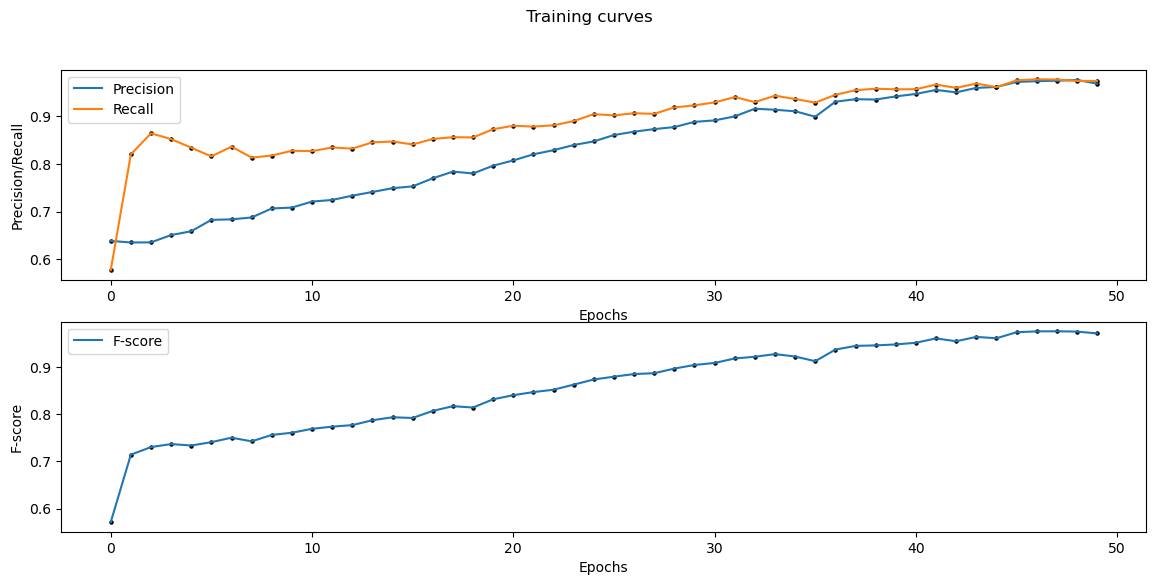

In [11]:
print("Temps d'entrainement : ", time_train, "s")

x = np.arange(len(history.history['loss']))

plt.figure(figsize=(14,6))
plt.suptitle(" Training curves")
plt.subplot(211)
plt.scatter(x,history.history['precision_m'], s=5, c='k')
plt.plot(history.history['precision_m'],label='Precision'), plt.legend()

plt.scatter(x,history.history['recall_m'], s=5, c='k')
plt.plot(history.history['recall_m'], label='Recall'), plt.legend()

plt.ylabel("Precision/Recall")
plt.xlabel("Epochs")

plt.subplot(212)
plt.scatter(x,history.history['f_score'], s=5, c='k')
plt.plot(history.history['f_score'], label='F-score'), plt.legend()
plt.ylabel("F-score")
plt.xlabel("Epochs")

In [12]:
#validation 
score = model.evaluate( x =[X_test1, X_test2], y =Y_test)
print("Validation F-score = ", 100*round(score[-1],4),"%")

116/116 [==============================] - 6s 46ms/step - loss: 1.0075 - binary_accuracy: 0.8265 - precision_m: 0.7922 - recall_m: 0.7568 - f_score: 0.7669
Validation F-score =  76.69 %


In [13]:
#data set 2 test for testing

X_LS_test = np.load("./data/set2/X_LS.npy", allow_pickle=True)
X_max_values_test = np.load("./data/set2/X_max_values.npy", allow_pickle=True)
Y_test = np.load("./data/set2/Y.npy", allow_pickle=True)

#shuffle
c = list(zip(X_LS_test, X_max_values_test,Y_test))
random.shuffle(c)
X_LS_test, X_max_values_test,Y_test = zip(*c)

#Periodogramme
X1_test_tensor = tf.convert_to_tensor(X_LS_test, dtype= 'float32')
X1_test_shape =  [len(X_LS_test),len(X_LS_test[0]), 1]
X1_test = tf.reshape(X1_test_tensor, X1_test_shape )
#Max values
X2_test_tensor = tf.convert_to_tensor(X_max_values_test, dtype= 'float32')
X2_test = tf.reshape(X2_test_tensor, (len(X_max_values_test), len(X_max_values_test[0]),1))
#Label
Y_test_tensor = tf.convert_to_tensor(Y_test)
label_test = tf.reshape(Y_test_tensor, (len(Y_test),1 ))

print("X1_test shape : ", X1_test.shape)
print("X2_test shape : ", X2_test.shape)
print("label_test shape : ", label_test.shape)

X1_test shape :  (3000, 990, 1)
X2_test shape :  (3000, 2, 1)
label_test shape :  (3000, 1)


In [14]:
#Evaluation 

score = model.evaluate( x =[X1_test[0:3000], X2_test[0:3000]], y=label_test[0:3000])
y_pred = model.predict(x =[X1_test[0:3000], X2_test[0:3000]])

94/94 [==============================] - 4s 42ms/step


tf.Tensor(
[[0.062     ]
 [0.48626128]], shape=(2, 1), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float64)
[0.09586096]


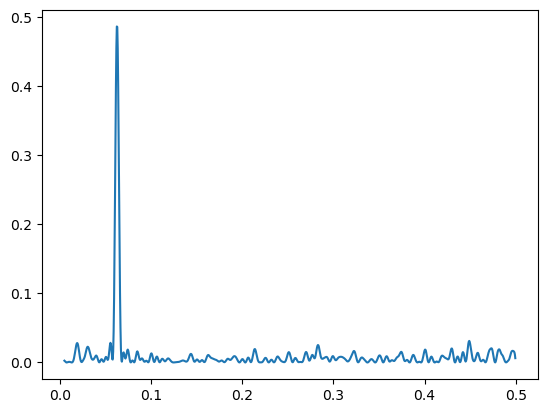

In [37]:
i = 44
print(X2_test[i])
print(label_test[i])
print(y_pred[i])
plt.plot(freq,X1_test[i])

In [15]:
#Evaluation with data from Nieto papers

label_test= []
LS_test = []
max_value_test =[]

for filename in np.sort(os.listdir("../Git_article/ExoplANNET/data")):
    
    if filename.endswith(".npy") :
        
        if filename.startswith("pe"): 
             LS_test.append(np.load('../Git_article/ExoplANNET/data/' + filename))
        if filename.startswith("l"): 
             label_test.append(np.load('../Git_article/ExoplANNET/data/' + filename))
        if filename.startswith("po"): 
             max_value_test.append(np.load('../Git_article/ExoplANNET/data/' + filename))

                
#Concatenate arrays
labels_p = np.concatenate((label_test[0][:],label_test[1][:],label_test[2][:],label_test[3][:],label_test[4][:]))
LSs_p = np.concatenate((LS_test[0][:], LS_test[1][:],LS_test[2][:],LS_test[3][:],LS_test[4][:]))
max_values_p = np.concatenate((max_value_test[0][:],max_value_test[1][:],max_value_test[2][:],max_value_test[3][:],max_value_test[4][:]) ) 

#Shuffle
c = list(zip(LSs_p, max_values_p,labels_p))
random.shuffle(c)
LSs_p, max_values_p,labels_p = zip(*c)

for i in range(len(max_values_p)):
    max_values_p[i][0] = freq[round(max_values_p[i][0])]

#Convert to tensor
X1_p = tf.convert_to_tensor(LSs_p, dtype= 'float32')
X_p_shape =  [len(LSs_p),len(X_LS[0]), 1]
X1_p = tf.reshape(X1_p, X_p_shape )

#Max values
X2_p = tf.convert_to_tensor(max_values_p, dtype= 'float32')
X2_p = tf.reshape(X2_p, (len(LSs_p), 2,1))

#Label
Y_p = tf.convert_to_tensor(labels_p)
Y_p = tf.reshape(Y_p, (len(LSs_p),1 ))


print("X1_test shape : ", X1_p.shape)
print("X2_test shape : ", X2_p.shape)
print("Y_test shape : ", Y_p.shape)

X1_test shape :  (20000, 990, 1)
X2_test shape :  (20000, 2, 1)
Y_test shape :  (20000, 1)


In [16]:
#Evaluation
score_p = model.evaluate( x =[X1_p[0:3000], X2_p[0:3000]], y =Y_p[0:3000])
print("Test F-score = ", 100*round(score_p[-1],4),"%")

94/94 [==============================] - 5s 51ms/step - loss: 6.1722 - binary_accuracy: 0.7773 - precision_m: 0.5075 - recall_m: 0.5232 - f_score: 0.4982
Test F-score =  49.82 %


In [17]:
test = model.predict(x =[X1_p[3000:6000], X2_p[3000:6000]])

94/94 [==============================] - 4s 40ms/step


In [18]:
test = (test>0.5)*1
accuracy = (test == np.reshape(np.asarray(labels_p[3000:6000]), (3000,1))).sum() / 3000
print("Accuracy score test on papers data : ", 100*round(accuracy,4),"%")

Accuracy score test on papers data :  78.33 %
